In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.models import Model

# Loading and preprocessing data

In [2]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

# labeling
fake_df['label'] = 'fake'
real_df['label'] = 'real'

# combine dfs
df = pd.concat ([fake_df,real_df], ignore_index = True)

# shuffle combined df
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# drop columns
df = df.drop(['title','subject','date'], axis=1)

# cleaning
df = df.dropna()
df = df.drop_duplicates(subset='text', keep='first') # dropping duplicates based on text

In [3]:
print(df["label"].value_counts(), '\n')
df.head()

label
real    21191
fake    17455
Name: count, dtype: int64 



,text,label
0,"21st Century Wire says Ben Stein, reputable pr...",fake
1,WASHINGTON (Reuters) - U.S. President Donald T...,real
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,real
3,"On Monday, Donald Trump once again embarrassed...",fake
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",real


### visualization

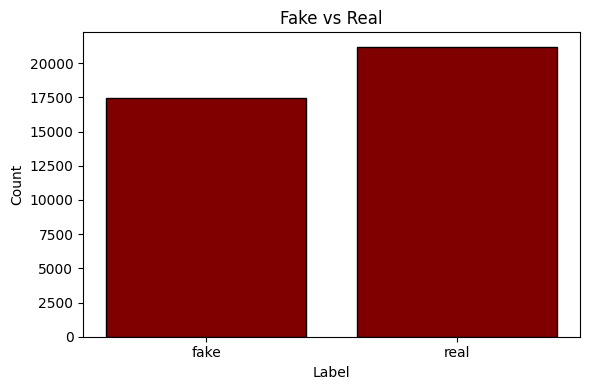

In [4]:
# fake vs real
counts = df['label'].value_counts().reindex(['fake','real']).fillna(0)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(counts.index, counts.values, color='maroon', edgecolor='black')

ax.set_title('Fake vs Real')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Splitting data

In [5]:
fake_news_df = df[['text','label']]
train_df_, test_df = train_test_split(fake_news_df, test_size=0.1, random_state=42, stratify=fake_news_df["label"])
train_df, valid_df = train_test_split(train_df_, test_size=0.1, random_state=42, stratify=train_df_["label"])

x_train = train_df["text"]
y_train_raw = train_df["label"]
x_valid = valid_df["text"]
y_valid_raw = valid_df["label"]
x_test = test_df["text"]
y_test_raw = test_df["label"]

In [6]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train_raw)
y_valid = encoder.transform(y_valid_raw)
y_test = encoder.transform(y_test_raw)

max_words = 5000
max_len = 1000

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_len, padding='post')
x_valid_seq = pad_sequences(tokenizer.texts_to_sequences(x_valid), maxlen=max_len, padding='post')
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len, padding='post')

# Building LSTM model

In [7]:
# input layer
text_input = Input(shape=(max_len,), name="text_input")

# embedding layer
text_emb = Embedding(input_dim=max_words, output_dim=128)(text_input)

# LSTM layer
text_lstm = LSTM(128)(text_emb)

# dense + dropout
x = Dense(64, activation='relu')(text_lstm)
x = Dropout(0.5)(x)

# output layer
output = Dense(1, activation='sigmoid')(x)  # binary classification

# build model
model = Model(inputs=text_input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1000, 128)           │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 779,905 (2.98 MB)

 Trainable params: 779,905 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    x_train_seq, y_train,
    validation_data=(x_valid_seq, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 269s 273ms/step - accuracy: 0.5576 - loss: 0.6815 - val_accuracy: 0.5622 - val_loss: 0.6761
Epoch 2/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 267s 272ms/step - accuracy: 0.5606 - loss: 0.6743 - val_accuracy: 0.5619 - val_loss: 0.6748
Epoch 3/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 260s 265ms/step - accuracy: 0.5614 - loss: 0.6708 - val_accuracy: 0.5611 - val_loss: 0.6769
Epoch 4/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 263s 269ms/step - accuracy: 0.6829 - loss: 0.5024 - val_accuracy: 0.9882 - val_loss: 0.0433
Epoch 5/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 265s 271ms/step - accuracy: 0.9958 - loss: 0.0214 - val_accuracy: 0.9986 - val_loss: 0.0060
Epoch 6/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 260s 266ms/step - accuracy: 0.9971 - loss: 0.0130 - val_accuracy: 0.9989 - val_loss: 0.0059
Epoch 7/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 258s 263ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9980 - val_loss: 0.0076
Epoch 8/10
979/979 ━━━━━━━━━━━━━━━━━━━━ 258s 264ms/step - accuracy: 0.9996 -

# evaluating model

In [10]:
test_loss, test_acc = model.evaluate(x_test_seq, y_test)
print("Test Accuracy:", test_acc)

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9992 - loss: 0.0056
Test Accuracy: 0.9992238283157349


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step

Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      1746
        real       1.00      1.00      1.00      2119

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



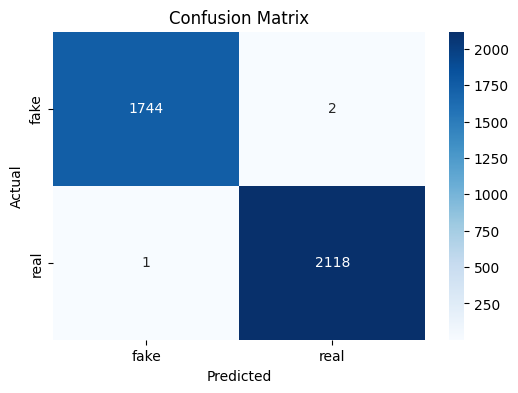

In [11]:
# predictions
y_pred_prob = model.predict(x_test_seq)
y_pred = (y_pred_prob > 0.5).astype(int)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# save tokenizer
with open("projectver2_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# save label encoder
with open("projectver2_label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

# save model
model.save("projectver2_fake_news_lstm_model.keras")